# Hyperparameter Tuning

Este notebook apresenta técnicas para otimização de hiperparâmetros.


In [1]:
# Imports básicos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Configuração de plotting
plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = (10, 6)

## Objetivos da Aula

- Grid Search
- Random Search
- Nested Cross-Validation
- Estratégias de otimização


In [2]:
# Criação de dataset sintético para demonstração
X, y = make_classification(
    n_samples=1000, n_features=10, n_redundant=0, n_informative=8, n_clusters_per_class=2, random_state=42
)

print(f"Dataset criado:")
print(f"- Número de amostras: {X.shape[0]}")
print(f"- Número de features: {X.shape[1]}")
print(f"- Distribuição de classes: {np.bincount(y)}")

# Configurar seed para reprodutibilidade
np.random.seed(42)

print("\n✅ Ambiente configurado com sucesso!")

Dataset criado:
- Número de amostras: 1000
- Número de features: 10
- Distribuição de classes: [499 501]

✅ Ambiente configurado com sucesso!


## 1. O que são Hiperparâmetros?

**Hiperparâmetros** são configurações do modelo que **não são aprendidas** durante o treinamento, mas devem ser definidas **antes** do processo de aprendizado.

### Exemplos de Hiperparâmetros:

- **Random Forest**: `n_estimators`, `max_depth`, `min_samples_split`
- **SVM**: `C`, `kernel`, `gamma`
- **Neural Networks**: `learning_rate`, `batch_size`, `hidden_layers`

### Por que otimizar?

A escolha inadequada de hiperparâmetros pode levar a:

- **Underfitting**: Modelo muito simples
- **Overfitting**: Modelo muito complexo
- **Performance subótima**: Não explorar o potencial máximo do modelo


🌳 Impacto do max_depth no Random Forest:
max_depth=3    → Accuracy: 0.780
max_depth=5    → Accuracy: 0.820
max_depth=10   → Accuracy: 0.835
max_depth=15   → Accuracy: 0.860
max_depth=None → Accuracy: 0.850


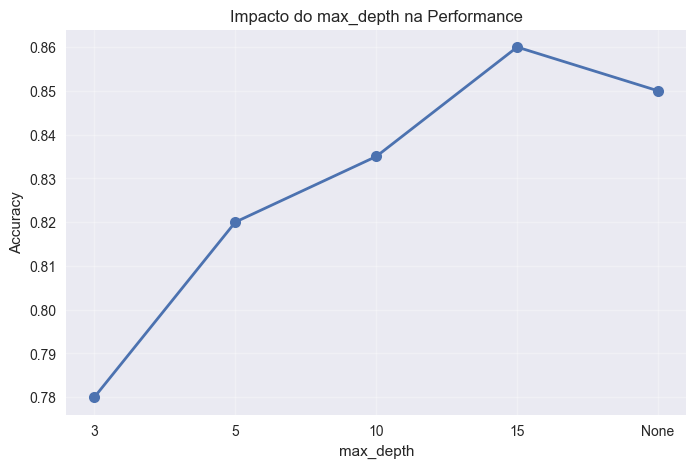


🎯 Melhor max_depth: 15 (Accuracy: 0.860)


In [3]:
# Exemplo: Impacto dos hiperparâmetros na performance
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split dos dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Testando diferentes valores de max_depth no Random Forest
depths = [3, 5, 10, 15, None]
scores = []

print("🌳 Impacto do max_depth no Random Forest:")
print("=" * 45)

for depth in depths:
    rf = RandomForestClassifier(n_estimators=100, max_depth=depth, random_state=42)
    rf.fit(X_train, y_train)
    score = accuracy_score(y_test, rf.predict(X_test))
    scores.append(score)
    print(f"max_depth={str(depth):4} → Accuracy: {score:.3f}")

# Visualização do impacto
plt.figure(figsize=(8, 5))
depth_labels = [str(d) if d is not None else "None" for d in depths]
plt.plot(depth_labels, scores, "o-", linewidth=2, markersize=8)
plt.title("Impacto do max_depth na Performance")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.grid(True, alpha=0.3)
plt.show()

print(f"\n🎯 Melhor max_depth: {depths[np.argmax(scores)]} (Accuracy: {max(scores):.3f})")

## 2. Grid Search

**Grid Search** é uma técnica que testa **todas as combinações** possíveis de hiperparâmetros em uma grade (grid) pré-definida.

### Vantagens:

- ✅ Garante encontrar a melhor combinação dentro da grade
- ✅ Fácil de implementar e entender

### Desvantagens:

- ❌ Computacionalmente custoso (crescimento exponencial)
- ❌ Limitado às combinações pré-definidas


In [4]:
# Grid Search com Random Forest
import time

# Definindo a grade de hiperparâmetros
param_grid = {"n_estimators": [50, 100, 200], "max_depth": [5, 10, 15], "min_samples_split": [2, 5, 10]}

print("🔍 Grid Search - Random Forest")
print("=" * 40)
print(f"Parâmetros a testar: {param_grid}")
print(f"Total de combinações: {3 * 3 * 3} = 27")

# Grid Search com Cross-Validation
start_time = time.time()

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring="accuracy",
    n_jobs=-1,  # Usar todos os cores disponíveis
    verbose=1,
)

grid_search.fit(X_train, y_train)

end_time = time.time()

print(f"\n⏱️ Tempo de execução: {end_time - start_time:.2f} segundos")
print(f"🏆 Melhor score: {grid_search.best_score_:.3f}")
print(f"🎯 Melhores parâmetros: {grid_search.best_params_}")

# Avaliação no conjunto de teste
best_model = grid_search.best_estimator_
test_score = accuracy_score(y_test, best_model.predict(X_test))
print(f"📊 Score no teste: {test_score:.3f}")

🔍 Grid Search - Random Forest
Parâmetros a testar: {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 15], 'min_samples_split': [2, 5, 10]}
Total de combinações: 27 = 27
Fitting 5 folds for each of 27 candidates, totalling 135 fits

⏱️ Tempo de execução: 9.54 segundos
🏆 Melhor score: 0.880
🎯 Melhores parâmetros: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
📊 Score no teste: 0.835


🏅 TOP 5 COMBINAÇÕES
1. Score: 0.880 (±0.023)
   Params: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}

2. Score: 0.880 (±0.024)
   Params: {'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 200}

3. Score: 0.878 (±0.029)
   Params: {'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 200}

4. Score: 0.877 (±0.020)
   Params: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}

5. Score: 0.877 (±0.023)
   Params: {'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 100}



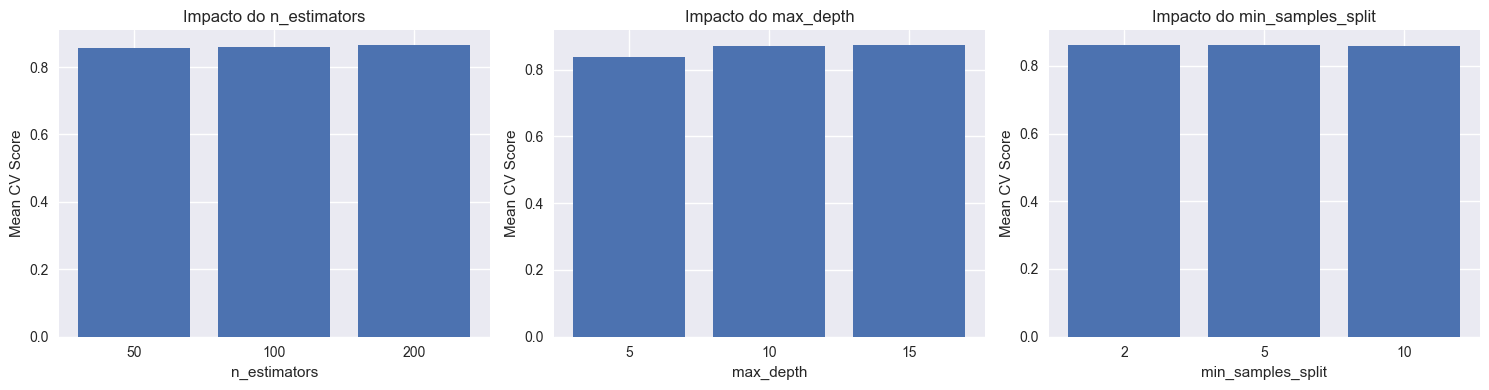

In [5]:
# Análise dos resultados do Grid Search
results_df = pd.DataFrame(grid_search.cv_results_)

# Top 5 combinações
print("🏅 TOP 5 COMBINAÇÕES")
print("=" * 50)
top_5 = results_df.nlargest(5, "mean_test_score")[["params", "mean_test_score", "std_test_score"]]

for i, (idx, row) in enumerate(top_5.iterrows()):
    print(f"{i+1}. Score: {row['mean_test_score']:.3f} (±{row['std_test_score']:.3f})")
    print(f"   Params: {row['params']}")
    print()

# Visualização do impacto dos hiperparâmetros
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Impacto do n_estimators
n_est_scores = results_df.groupby("param_n_estimators")["mean_test_score"].mean()
axes[0].bar(range(len(n_est_scores)), n_est_scores.values)
axes[0].set_title("Impacto do n_estimators")
axes[0].set_xlabel("n_estimators")
axes[0].set_ylabel("Mean CV Score")
axes[0].set_xticks(range(len(n_est_scores)))
axes[0].set_xticklabels(n_est_scores.index)

# Impacto do max_depth
depth_scores = results_df.groupby("param_max_depth")["mean_test_score"].mean()
axes[1].bar(range(len(depth_scores)), depth_scores.values)
axes[1].set_title("Impacto do max_depth")
axes[1].set_xlabel("max_depth")
axes[1].set_ylabel("Mean CV Score")
axes[1].set_xticks(range(len(depth_scores)))
axes[1].set_xticklabels(depth_scores.index)

# Impacto do min_samples_split
split_scores = results_df.groupby("param_min_samples_split")["mean_test_score"].mean()
axes[2].bar(range(len(split_scores)), split_scores.values)
axes[2].set_title("Impacto do min_samples_split")
axes[2].set_xlabel("min_samples_split")
axes[2].set_ylabel("Mean CV Score")
axes[2].set_xticks(range(len(split_scores)))
axes[2].set_xticklabels(split_scores.index)

plt.tight_layout()
plt.show()

## 3. Random Search

**Random Search** amostra **aleatoriamente** combinações de hiperparâmetros de distribuições definidas.

### Vantagens:

- ✅ Mais eficiente que Grid Search para espaços grandes
- ✅ Pode encontrar combinações não previstas
- ✅ Controle do tempo de execução (número de iterações)

### Desvantagens:

- ❌ Não garante encontrar o ótimo global
- ❌ Resultados podem variar entre execuções


In [6]:
# Random Search com distribuições contínuas
from scipy.stats import randint, uniform

# Definindo distribuições para os hiperparâmetros
param_distributions = {
    "n_estimators": randint(50, 300),  # Inteiros de 50 a 299
    "max_depth": randint(3, 20),  # Inteiros de 3 a 19
    "min_samples_split": randint(2, 20),  # Inteiros de 2 a 19
    "min_samples_leaf": randint(1, 10),  # Inteiros de 1 a 9
    "max_features": uniform(0.1, 0.9),  # Float de 0.1 a 1.0
}

print("🎲 Random Search - Random Forest")
print("=" * 40)
print("Distribuições dos parâmetros:")
for param, dist in param_distributions.items():
    print(f"- {param}: {dist}")

# Random Search
start_time = time.time()

random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_distributions,
    n_iter=50,  # 50 iterações aleatórias
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    random_state=42,
    verbose=1,
)

random_search.fit(X_train, y_train)

end_time = time.time()

print(f"\n⏱️ Tempo de execução: {end_time - start_time:.2f} segundos")
print(f"🏆 Melhor score: {random_search.best_score_:.3f}")
print(f"🎯 Melhores parâmetros: {random_search.best_params_}")

# Comparação com Grid Search
print(f"\n📊 COMPARAÇÃO")
print("=" * 30)
print(f"Grid Search:   {grid_search.best_score_:.3f}")
print(f"Random Search: {random_search.best_score_:.3f}")

# Avaliação no teste
random_test_score = accuracy_score(y_test, random_search.best_estimator_.predict(X_test))
print(f"\nScore no teste:")
print(f"Grid Search:   {test_score:.3f}")
print(f"Random Search: {random_test_score:.3f}")

🎲 Random Search - Random Forest
Distribuições dos parâmetros:
- n_estimators: <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001BC1D1ED370>
- max_depth: <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001BC1DA38080>
- min_samples_split: <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001BC1B815F40>
- min_samples_leaf: <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001BC1D993EF0>
- max_features: <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001BC20D9BFB0>
Fitting 5 folds for each of 50 candidates, totalling 250 fits

⏱️ Tempo de execução: 11.53 segundos
🏆 Melhor score: 0.882
🎯 Melhores parâmetros: {'max_depth': 19, 'max_features': 0.3401029128477565, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 269}

📊 COMPARAÇÃO
Grid Search:   0.880
Random Search: 0.882

Score no teste:
Grid Search:   0.835
Random Search: 0.855


## 4. Nested Cross-Validation

**Nested CV** é a forma **correta** de avaliar a performance de um modelo quando fazemos hyperparameter tuning.

### Por que usar?

- **Problema**: Usar o mesmo conjunto para tuning e avaliação leva a **overfitting**
- **Solução**: CV externo para avaliação + CV interno para tuning

### Estrutura:

```
Outer CV (avaliação):
├── Fold 1: Inner CV (tuning) → Melhor modelo → Avaliação
├── Fold 2: Inner CV (tuning) → Melhor modelo → Avaliação
└── Fold 3: Inner CV (tuning) → Melhor modelo → Avaliação
```


In [7]:
# Implementando Nested Cross-Validation
from sklearn.model_selection import StratifiedKFold

# Configuração dos CVs
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Grid mais simples para demonstração
simple_param_grid = {"n_estimators": [50, 100], "max_depth": [5, 10, None]}

print("🔄 Nested Cross-Validation")
print("=" * 40)
print(f"Outer CV: {outer_cv.n_splits} folds")
print(f"Inner CV: {inner_cv.n_splits} folds")

# Implementação manual do Nested CV
nested_scores = []
best_params_per_fold = []

for fold, (train_idx, val_idx) in enumerate(outer_cv.split(X, y)):
    print(f"\n📁 Outer Fold {fold + 1}")

    # Split dos dados do outer fold
    X_train_outer, X_val_outer = X[train_idx], X[val_idx]
    y_train_outer, y_val_outer = y[train_idx], y[val_idx]

    # Inner CV para hyperparameter tuning
    inner_grid = GridSearchCV(
        RandomForestClassifier(random_state=42), simple_param_grid, cv=inner_cv, scoring="accuracy"
    )

    inner_grid.fit(X_train_outer, y_train_outer)

    # Avaliação no validation set do outer fold
    best_model = inner_grid.best_estimator_
    score = accuracy_score(y_val_outer, best_model.predict(X_val_outer))

    nested_scores.append(score)
    best_params_per_fold.append(inner_grid.best_params_)

    print(f"   Melhores params: {inner_grid.best_params_}")
    print(f"   Score: {score:.3f}")

# Resultado final
mean_score = np.mean(nested_scores)
std_score = np.std(nested_scores)

print(f"\n🎯 RESULTADO FINAL")
print("=" * 30)
print(f"Nested CV Score: {mean_score:.3f} ± {std_score:.3f}")
print(f"Scores por fold: {[f'{s:.3f}' for s in nested_scores]}")

# Comparação com validação "ingênua"
naive_score = grid_search.best_score_
print(f"\n📊 COMPARAÇÃO")
print("=" * 20)
print(f"Validação 'ingênua': {naive_score:.3f}")
print(f"Nested CV:          {mean_score:.3f} ± {std_score:.3f}")
print("\n⚠️  A diferença mostra o overfitting do tuning!")

🔄 Nested Cross-Validation
Outer CV: 5 folds
Inner CV: 3 folds

📁 Outer Fold 1
   Melhores params: {'max_depth': 10, 'n_estimators': 100}
   Score: 0.910

📁 Outer Fold 2
   Melhores params: {'max_depth': None, 'n_estimators': 100}
   Score: 0.855

📁 Outer Fold 3
   Melhores params: {'max_depth': None, 'n_estimators': 100}
   Score: 0.890

📁 Outer Fold 4
   Melhores params: {'max_depth': 10, 'n_estimators': 100}
   Score: 0.855

📁 Outer Fold 5
   Melhores params: {'max_depth': 10, 'n_estimators': 100}
   Score: 0.880

🎯 RESULTADO FINAL
Nested CV Score: 0.878 ± 0.021
Scores por fold: ['0.910', '0.855', '0.890', '0.855', '0.880']

📊 COMPARAÇÃO
Validação 'ingênua': 0.880
Nested CV:          0.878 ± 0.021

⚠️  A diferença mostra o overfitting do tuning!


## 5. Estratégias Práticas de Otimização

### 🎯 Boas Práticas:

1. **Comece simples**: Teste ranges amplos primeiro
2. **Use Random Search**: Para exploração inicial
3. **Refine com Grid Search**: Em regiões promissoras
4. **Monitore overfitting**: Use Nested CV para avaliação final
5. **Considere o custo computacional**: Balance precisão vs tempo

### 📊 Quando usar cada método:

| Método                    | Situação                  | Vantagem            |
| ------------------------- | ------------------------- | ------------------- |
| **Manual**                | Poucos hiperparâmetros    | Controle total      |
| **Grid Search**           | Espaço pequeno e discreto | Garantia de ótimo   |
| **Random Search**         | Espaço grande ou contínuo | Eficiência          |
| **Bayesian Optimization** | Função cara de avaliar    | Menor n° avaliações |


In [8]:
# Exemplo: Estratégia híbrida (Random + Grid)
print("🚀 ESTRATÉGIA HÍBRIDA")
print("=" * 30)

# Passo 1: Random Search para exploração ampla
print("Passo 1: Exploração com Random Search...")

broad_distributions = {
    "n_estimators": randint(10, 500),
    "max_depth": randint(1, 30),
    "min_samples_split": randint(2, 50),
    "min_samples_leaf": randint(1, 20),
}

# Random search com muitas iterações
exploration = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    broad_distributions,
    n_iter=30,
    cv=3,
    scoring="accuracy",
    n_jobs=-1,
    random_state=42,
)

exploration.fit(X_train, y_train)
best_broad = exploration.best_params_

print(f"Melhor região encontrada: {best_broad}")

# Passo 2: Grid Search refinado na região promissora
print("\nPasso 2: Refinamento com Grid Search...")

# Definir grid ao redor dos melhores valores
refined_grid = {
    "n_estimators": [
        max(10, best_broad["n_estimators"] - 50),
        best_broad["n_estimators"],
        best_broad["n_estimators"] + 50,
    ],
    "max_depth": [max(1, best_broad["max_depth"] - 2), best_broad["max_depth"], best_broad["max_depth"] + 2],
    "min_samples_split": [
        max(2, best_broad["min_samples_split"] - 2),
        best_broad["min_samples_split"],
        min(50, best_broad["min_samples_split"] + 2),
    ],
}

refinement = GridSearchCV(RandomForestClassifier(random_state=42), refined_grid, cv=5, scoring="accuracy", n_jobs=-1)

refinement.fit(X_train, y_train)

print(f"Melhores parâmetros refinados: {refinement.best_params_}")
print(f"Score final: {refinement.best_score_:.3f}")

# Comparação final
final_test_score = accuracy_score(y_test, refinement.best_estimator_.predict(X_test))

print(f"\n📈 COMPARAÇÃO FINAL NO TESTE")
print("=" * 35)
print(f"Grid Search simples:    {test_score:.3f}")
print(f"Random Search:          {random_test_score:.3f}")
print(f"Estratégia híbrida:     {final_test_score:.3f}")

print(
    f"\n🎯 Melhor abordagem: {'Híbrida' if final_test_score == max(test_score, random_test_score, final_test_score) else 'Outra'}"
)

🚀 ESTRATÉGIA HÍBRIDA
Passo 1: Exploração com Random Search...
Melhor região encontrada: {'max_depth': 15, 'min_samples_leaf': 3, 'min_samples_split': 15, 'n_estimators': 90}

Passo 2: Refinamento com Grid Search...
Melhores parâmetros refinados: {'max_depth': 17, 'min_samples_split': 13, 'n_estimators': 90}
Score final: 0.878

📈 COMPARAÇÃO FINAL NO TESTE
Grid Search simples:    0.835
Random Search:          0.855
Estratégia híbrida:     0.850

🎯 Melhor abordagem: Outra


## 6. Resumo e Boas Práticas

### 🎯 Principais Takeaways:

1. **Hiperparâmetros são cruciais** para performance dos modelos
2. **Grid Search**: Exaustivo mas garantido (espaços pequenos)
3. **Random Search**: Eficiente para exploração (espaços grandes)
4. **Nested CV**: Avaliação não enviesada com tuning
5. **Estratégia híbrida**: Exploração + refinamento

### ⚠️ Armadilhas Comuns:

- **Data leakage**: Não usar dados de teste para tuning
- **Overfitting do tuning**: Muitas iterações sem validação externa
- **Ignorar o custo computacional**: Balance eficiência vs precisão
- **Grid muito denso**: Pode não melhorar significativamente

### 🚀 Próximos Passos:

- **Bayesian Optimization**: Para otimização mais inteligente
- **Multi-objective optimization**: Balance entre métricas
- **Early stopping**: Para modelos iterativos
- **AutoML**: Automatização completa do processo


In [9]:
# Função utilitária para hyperparameter tuning
def optimize_hyperparameters(
    estimator, param_grid, X, y, method="grid", n_iter=50, cv=5, scoring="accuracy", random_state=42
):
    """
    Função utilitária para otimização de hiperparâmetros

    Parameters:
    -----------
    estimator : sklearn estimator
        Modelo a ser otimizado
    param_grid : dict
        Grade ou distribuições de parâmetros
    X, y : array-like
        Dados de treino
    method : str, default='grid'
        Método de busca ('grid' ou 'random')
    n_iter : int, default=50
        Número de iterações para random search
    cv : int, default=5
        Número de folds para cross-validation
    scoring : str, default='accuracy'
        Métrica de avaliação
    random_state : int, default=42
        Seed para reprodutibilidade

    Returns:
    --------
    Best estimator fitted
    """

    if method == "grid":
        search = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=cv, scoring=scoring, n_jobs=-1)
    elif method == "random":
        search = RandomizedSearchCV(
            estimator=estimator,
            param_distributions=param_grid,
            n_iter=n_iter,
            cv=cv,
            scoring=scoring,
            n_jobs=-1,
            random_state=random_state,
        )
    else:
        raise ValueError("method deve ser 'grid' ou 'random'")

    search.fit(X, y)

    print(f"🏆 Melhor score ({method}): {search.best_score_:.3f}")
    print(f"🎯 Melhores parâmetros: {search.best_params_}")

    return search.best_estimator_


# Exemplo de uso da função
print("🛠️ FUNÇÃO UTILITÁRIA")
print("=" * 25)

# Teste rápido
quick_grid = {"n_estimators": [50, 100], "max_depth": [5, 10]}
best_rf = optimize_hyperparameters(
    RandomForestClassifier(random_state=42), quick_grid, X_train, y_train, method="grid"
)

🛠️ FUNÇÃO UTILITÁRIA
🏆 Melhor score (grid): 0.870
🎯 Melhores parâmetros: {'max_depth': 10, 'n_estimators': 50}
